In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("/workspace/circuit-finder")

In [3]:
dataset_name = 'gender-bias'
metric_fn_name = "logit_diff"

In [4]:
import pickle
from circuit_finder.constants import ProjectDir
from circuit_finder.experiments.run_leap_experiment import LeapExperimentResult

with open(ProjectDir / 'leap_experiment_results' / f'dataset={dataset_name}_threshold=0.01' / 'result.pkl', 'rb') as file:
    result = pickle.load(file)

print(result)

LeapExperimentResult(config=LEAPConfig(threshold=0.01, contrast_pairs=True, chained_attribs=True, store_error_attribs=True, qk_enabled=True, allow_neg_feature_acts=True), clean_metric=0.7484140396118164, corrupt_metric=-3.045534133911133, graph=<circuit_finder.patching.eap_graph.EAPGraph object at 0x7f75646e53c0>, error_graph=<circuit_finder.patching.eap_graph.EAPGraph object at 0x7f75646e7310>)


In [5]:
from circuit_finder.pretrained import load_model
from circuit_finder.pretrained import load_attn_saes, load_hooked_mlp_transcoders
from circuit_finder.patching.indirect_leap import preprocess_attn_saes

model = load_model()
attn_sae_dict = load_attn_saes()
# TODO: get rid of need to preprocess attn saes
attn_sae_dict = preprocess_attn_saes(attn_sae_dict, model)
hooked_mlp_transcoder_dict = load_hooked_mlp_transcoders()

attn_saes = list(attn_sae_dict.values())
transcoders = list(hooked_mlp_transcoder_dict.values())

/workspace/circuit-finder/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2 into HookedTransformer


Fetching 26 files:   0%|          | 0/26 [00:00<?, ?it/s]

In [6]:
from circuit_finder.experiments.run_leap_experiment import datasets, compute_logit_diff

dataset = datasets[dataset_name]

# Setup the tokens
clean_tokens = dataset.clean_tokens(model)
answer_tokens = dataset.answer_tokens(model)
wrong_answer_tokens = dataset.wrong_answer_tokens(model)
corrupt_tokens = dataset.corrupt_tokens(model)

# Setup the metric function
if metric_fn_name == "logit_diff":

    def metric_fn(model, tokens):
        logit_diff = compute_logit_diff(
            model, tokens, answer_tokens, wrong_answer_tokens
        )
        return logit_diff.mean()
else:
    raise ValueError(f"Unknown metric_fn_name: {metric_fn_name}")

In [7]:
graph = result.graph

In [8]:
all_nodes = graph.get_src_nodes()
all_nodes = [n for n in all_nodes if "metric" not in n]
print(len(all_nodes))

160


# Causal Ablations

## Value Patching

In [9]:
# Get the clean and corrupt cache
from circuit_finder.patching.ablate import (
    splice_model_with_saes_and_transcoders,
    filter_sae_acts_and_errors,
    get_ablation_result,
)

with splice_model_with_saes_and_transcoders(
    model, transcoders, attn_saes
) as spliced_model:
    _, clean_cache = model.run_with_cache(
        clean_tokens, names_filter=filter_sae_acts_and_errors
    )
    _, corrupt_cache = model.run_with_cache(
        corrupt_tokens, names_filter=filter_sae_acts_and_errors
    )

noising_result = get_ablation_result(
    model,
    transcoders,
    attn_saes,
    clean_tokens = clean_tokens,
    corrupt_tokens = corrupt_tokens,
    clean_cache = clean_cache,
    corrupt_cache = corrupt_cache,
    nodes = all_nodes,
    metric_fn = metric_fn,
    setting="noising",
)

denoising_result = get_ablation_result(
    model,
    transcoders,
    attn_saes,
    clean_tokens = clean_tokens,
    corrupt_tokens = corrupt_tokens,
    clean_cache = clean_cache,
    corrupt_cache = corrupt_cache,
    nodes = all_nodes,
    metric_fn = metric_fn,
    setting="denoising",
)

In [10]:
print(noising_result)
print(denoising_result)

AblationResult(coefficient=[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0], metric=[-2.821636199951172, -2.5371875762939453, -2.189973831176758, -1.8430681228637695, -1.5059776306152344, -1.1809062957763672, -0.8390083312988281, -0.48701953887939453, -0.14567947387695312, 0.25039100646972656, 0.7484140396118164])
AblationResult(coefficient=[1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.3999999999999999, 0.29999999999999993, 0.19999999999999996, 0.09999999999999998, 0.0], metric=[0.009627342224121094, -0.3280010223388672, -0.6473398208618164, -0.9715509414672852, -1.29791259765625, -1.6100854873657227, -1.9164438247680664, -2.22383975982666, -2.5474071502685547, -2.8072509765625, -3.0455322265625])


In [11]:
clean_metric = result.clean_metric
corrupt_metric = result.corrupt_metric

results = {
    "noising": noising_result,
    "denoising": denoising_result,
}

Text(0, 0.5, 'Metric')

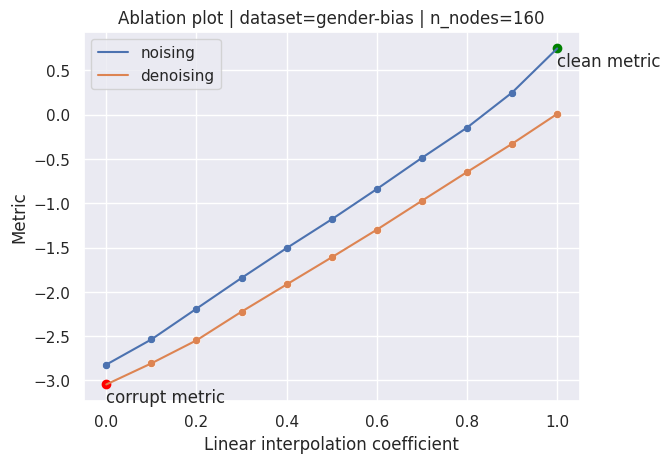

In [12]:
# Plot the results

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
for setting, res in results.items():
    coefficients = res.coefficient
    metrics = res.metric
    sns.lineplot(x=coefficients, y=metrics, label=setting)
    sns.scatterplot(x=coefficients, y=metrics)
plt.legend()
# Add text
text_offset = -0.2
plt.scatter([1], [clean_metric], color="green")
plt.text(1, clean_metric + text_offset, "clean metric", fontsize=12)
plt.scatter([0], [corrupt_metric], color="red")
plt.text(0, corrupt_metric + text_offset, "corrupt metric", fontsize=12)

plt.title(f"Ablation plot | dataset={dataset_name} | n_nodes={len(all_nodes)}")
plt.xlabel("Linear interpolation coefficient")
plt.ylabel("Metric")

## Delta Patching

Value patching has the problem that patching at later layers "covers up" the effect from earlier layers. Let's look at what happens instead if we do delta patching. 



In [24]:
from circuit_finder.patching.ablate import (
    get_circuit_node_delta_patch_hooks,
    AblationResult,
)

coefs = []
metrics = []

# Denoising: Start with corrupt tokens, and patch in deltas towards clean
with splice_model_with_saes_and_transcoders(
    model,  # type: ignore
    transcoders,
    attn_saes,
) as spliced_model:
    for coefficient in coefficients:
        fwd_hooks = get_circuit_node_delta_patch_hooks(
            clean_cache, all_nodes, coefficient
        )
        with model.hooks(fwd_hooks=fwd_hooks):
            metric = metric_fn(model, corrupt_tokens).item()
            metrics.append(metric)
            coefs.append(coefficient)

denoising_result = AblationResult(
    coefficient=coefs,
    metric=metrics,
)

# Noising: Start with clean tokens, and patch in deltas towards corrupt

coefs = []
metrics = []

with splice_model_with_saes_and_transcoders(
    model,  # type: ignore
    transcoders,
    attn_saes,
) as spliced_model:
    for coefficient in coefficients:
        fwd_hooks = get_circuit_node_delta_patch_hooks(
            corrupt_cache, all_nodes, coefficient
        )
        with model.hooks(fwd_hooks=fwd_hooks):
            # NOTE: In the noising setting, we are using clean_tokens instead of corrupt tokens
            metric = metric_fn(model, clean_tokens).item()
            metrics.append(metric)
            # NOTE: In the noising setting, we are using 1 - coefficient.
            coefs.append(1 - coefficient)

noising_result = AblationResult(
    coefficient=coefs,
    metric=metrics,
)

results = {
    "noising": noising_result,
    "denoising": denoising_result,
}

In [25]:
print(results)

{'noising': AblationResult(coefficient=[0.0, 0.09999999999999998, 0.19999999999999996, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.3999999999999999, 0.29999999999999993, 0.19999999999999996, 0.09999999999999998, 0.0], metric=[-2.8216419219970703, -2.7276830673217773, -2.578042984008789, -2.3627138137817383, -2.091371536254883, -1.7629308700561523, -1.375619888305664, -0.9271011352539062, -0.43567943572998047, 0.11906147003173828, 0.7484140396118164, 0.7484140396118164, 0.11906147003173828, -0.43567943572998047, -0.9271011352539062, -1.375619888305664, -1.7629308700561523, -2.091371536254883, -2.3627138137817383, -2.578042984008789, -2.7276830673217773, -2.8216419219970703]), 'denoising': AblationResult(coefficient=[1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.3999999999999999, 0.29999999999999993, 0.19999999999999996, 0.09999999999999998, 0.0, 0.0, 0.09999999999999998, 0.19999999999999996, 0.30000000000000004, 0.4, 0.5, 0.600

Text(0, 0.5, 'Metric')

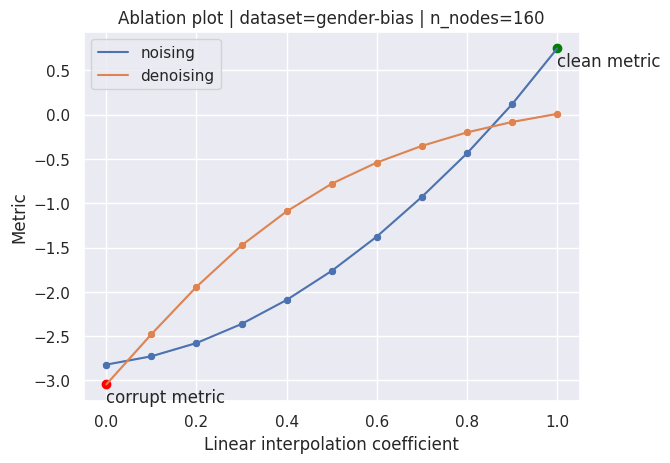

In [26]:
# Plot the results

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
for setting, res in results.items():
    coefficients = res.coefficient
    metrics = res.metric
    sns.lineplot(x=coefficients, y=metrics, label=setting)
    sns.scatterplot(x=coefficients, y=metrics)
plt.legend()
# Add text
text_offset = -0.2
plt.scatter([1], [clean_metric], color="green")
plt.text(1, clean_metric + text_offset, "clean metric", fontsize=12)
plt.scatter([0], [corrupt_metric], color="red")
plt.text(0, corrupt_metric + text_offset, "corrupt metric", fontsize=12)

plt.title(f"Ablation plot | dataset={dataset_name} | n_nodes={len(all_nodes)}")
plt.xlabel("Linear interpolation coefficient")
plt.ylabel("Metric")